# Projeto 4 de Modelagem Matemática: Simulando EDPs

#### Leonardo Bohac (entregue em 11/06/2019)

Neste projeto vamos simular uma onda propagando-se em um meio sem e com obstáculos. Em cada um destes cenários, contemplaremos visualmente o comportamento da onda, e também veremos como a sua energia é distribuída nos lados do meio de propagação. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

### Propagação da onda

Na célula abaixo são definidas as dimensões da malha, bem como o refinamento de sua discretização.

In [2]:
N = int(1e3)    # número de pontos por unidade (de comprimento e de tempo)
dt = 1/N        # infinitesimal do tempo (que será o mesmo que dx e dy)

Lx = 2          # largura da malha (em metros)
Ly = 1          # altura da malha (em metros)

W = N*Lx        # quantidade de pontos no eixo horizontal
H = N*Ly        # quantidade de pontos no eixo vertical

X = np.linspace(0, Lx, W)    # eixo horizontal
Y = np.linspace(0, Ly, H)    # eixo vertical

Abaixo definimos a função que inicializa a onda, segundo as especifiações do projeto.

In [3]:
def InitializeWave():
    
    Wave = np.array(np.meshgrid(X, Y))
        
    Wave = np.dstack((Wave[0], Wave[1])).reshape(H*W, 2)
        
    def f(x, y, x0=0.5, y0=0.5, r=0.1):
        
        def gaussian(d, sigma=r/3):
        
            return  (1/np.sqrt(2*np.pi*sigma**2)) * np.exp((-d**2)/(2*sigma**2))
    
        d = np.sqrt((x-x0)**2+(y-y0)**2)
    
        return np.where(d > r, 0, gaussian(d))
    
    Wave = f(Wave.T[1], Wave.T[0]).reshape(H, W)
    
    return Wave

In [4]:
Wave = InitializeWave()

Visualização da onda no instante inicial:

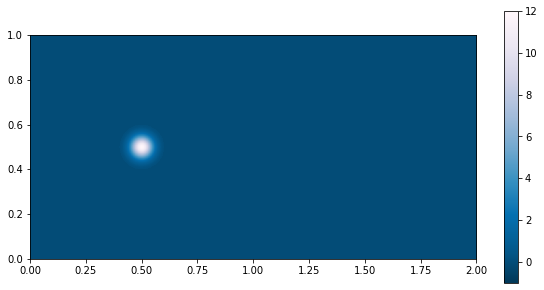

In [5]:
plt.figure(figsize=(10,5))
plt.imshow(Wave, extent=[0, Lx, 0, Ly], vmax=12, vmin=-1, cmap='PuBu_r');
plt.colorbar();

As animações com a evolução da onda foram produzidas no caderno *Plotting.ipynb* e são exibidas abaixo:

In [6]:
# Versão bidimensional
HTML('<img src="Onda.gif">')

In [7]:
# Versão tridimensional
HTML('<img src="Onda_3D.gif">')

Agora adicionaremos obstáculos no meio de propagação. Para isso, vou criar uma "máscara" (uma matriz) que será multiplicada (componente-a-componente) pela matriz da onda no início de cada iteração. Esta máscara possui o valor 0 nas entradas onde estão localizados os obstáculos, e o valor 1 no restante. 

In [8]:
def ObstacleMask(m=10, h=50, a=2):
    
    # m = número de obstáculos (só está implementado para números pares)
    # h = altura de cada obstáculo (em quantidade de pontos)
    # a = largura de cada obstáculo (em quantidade de pontos)
    
    Mask = np.ones((H, W)).T
    
    MiddleX = int(W/2)
    MiddleY = int(H/2)
    
    Obstacle_cols = np.arange(MiddleX-int(a/2), MiddleX+int(a/2))
    
    lh = h*dt
    
    d = int((Ly - m*lh)/(m-1)/dt)
    
    ObstacleRows = np.ones(H)
    
    for j in range(int(m/2)):
        
        itop = j*(h+d)
        
        ObstacleRows[itop:itop+h] = 0
        
    FilledAlready = np.argwhere(ObstacleRows == 0).flatten()

    ObstacleRows[H - FilledAlready - 1] = 0
    
    Mask[Obstacle_cols] = ObstacleRows
    
    return Mask.T

Visualizando a máscara de obstáculos:

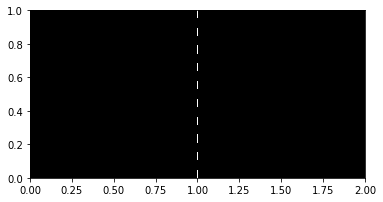

In [9]:
plt.imshow(ObstacleMask(), extent=[0, Lx, 0, Ly], cmap='gray_r');

Com isso, podemos computar a evolução da onda em um meio com obstáculos. Novamente, os cálculos e as animações são feitos no arquivo *Plotting.ipynb*.

In [10]:
# Obstáculos de tamanho 50
HTML('<img src="Onda_Obstáculos_050.gif">')

In [11]:
# Obstáculos de tamanho 100 (uma barreira completa)
HTML('<img src="Onda_Obstáculos_100.gif">')

### Análise energética da onda

Vamos calcular as energias da onda, do lado esquerdo e lado direito do meio de propagação, para diferentes tamanhos de obstáculos.

In [12]:
def Energies(steps, Mask):
    
    def Laplacian(U):
    
        D2Y = np.gradient(np.gradient(U, axis=0), axis=0) / dt**2
    
        D2X = np.gradient(np.gradient(U, axis=1), axis=1) / dt**2
    
        return D2Y + D2X
    
    def Next_Ut(U, Ut):
    
        Utt = Laplacian(U)
    
        return Ut + Utt*dt
    
    def Next_U(U, Ut):
    
        return U + Ut*dt
    
    
    midW = int(W/2)
    
    L_Energy = np.zeros(steps)
    R_Energy = np.zeros(steps)
    
    Wave = InitializeWave() * Mask
    Ut = np.zeros((H, W))
    
    for s in range(steps):
        
        DX = np.gradient(Wave, axis=1) / dt
        DY = np.gradient(Wave, axis=0) / dt

        Next_Wave = Next_U(Wave, Ut) * Mask
        
        Next_Wave[ 0, :] = np.zeros(W)
        Next_Wave[-1, :] = np.zeros(W)
        Next_Wave[:,  0] = np.zeros(H)
        Next_Wave[:, -1] = np.zeros(H)
        
        DT = (Next_Wave - Wave) / dt

        Energy = (1/2)*(DT**2 + DX**2 + DY**2)
    
        lE = Energy[:,:midW]
        rE = Energy[:,midW:]
        
        L_Energy[s] = np.sum(lE) * dt
        R_Energy[s] = np.sum(rE) * dt
        
        Wave = Next_Wave
        
        Ut = Next_Ut(Wave, Ut)
    
    
    return np.vstack([L_Energy, R_Energy])

In [13]:
# Criando diferentes máscaras de obstáculos

m = 10

ObstacleMask_00 = ObstacleMask(m, 0)  # 10 obstáculos, cada um com altura 0 (ou seja, nenhum obstáculo)
ObstacleMask_10 = ObstacleMask(m,10)  # 10 obstáculos, cada um com altura 10
ObstacleMask_25 = ObstacleMask(m,25)  # 10 obstáculos, cada um com altura 25
ObstacleMask_50 = ObstacleMask(m,50)  # 10 obstáculos, cada um com altura 50
ObstacleMask_75 = ObstacleMask(m,75)  # 10 obstáculos, cada um com altura 75

In [ ]:
# Cálculo das Energias (Não precisa rodar esta célula denovo, pois ela demora. Os resultados foram salvos e são abertos na célula seguinte)

steps = 30000  # total de 30 segundos

Energies_00 = Energies(steps, ObstacleMask_00)
Energies_10 = Energies(steps, ObstacleMask_10)
Energies_25 = Energies(steps, ObstacleMask_25)
Energies_50 = Energies(steps, ObstacleMask_50)
Energies_75 = Energies(steps, ObstacleMask_75)

In [14]:
Energies_00 = np.load('./Energies/Energies_00.npy')
Energies_10 = np.load('./Energies/Energies_10.npy')
Energies_25 = np.load('./Energies/Energies_25.npy')
Energies_50 = np.load('./Energies/Energies_50.npy')
Energies_75 = np.load('./Energies/Energies_75.npy')

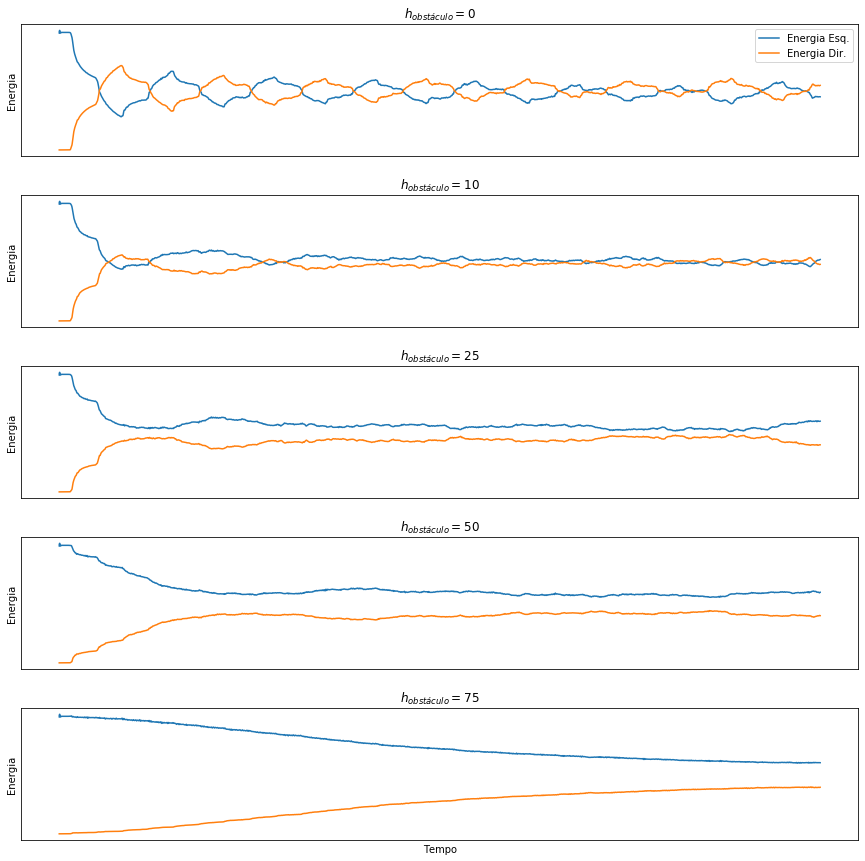

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(15,15))

plt.subplots_adjust(hspace=0.3)

ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('Energia');
ax1.set_title(r'$h_{obstáculo} = 0$')
ax1.plot(Energies_00[0], label='Energia Esq.');
ax1.plot(Energies_00[1], label='Energia Dir.');
ax1.legend(loc=1)

ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel('Energia');
ax2.set_title(r'$h_{obstáculo} = 10$')
ax2.plot(Energies_10[0]);
ax2.plot(Energies_10[1]);

ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('Energia');
ax3.set_title(r'$h_{obstáculo} = 25$')
ax3.plot(Energies_25[0]);
ax3.plot(Energies_25[1]);

ax4.set_yticks([])
ax4.set_xticks([])
ax4.set_ylabel('Energia');
ax4.set_title(r'$h_{obstáculo} = 50$')
ax4.plot(Energies_50[0]);
ax4.plot(Energies_50[1]);

ax5.set_yticks([])
ax5.set_xticks([])
ax5.set_ylabel('Energia');
ax5.set_title(r'$h_{obstáculo} = 75$')
ax5.plot(Energies_75[0]);
ax5.plot(Energies_75[1]);

ax5.set_xlabel('Tempo');

Analisando os gráficos, vemos que a distribuição de energia nos dois lados do meio de propagação se comporta de maneira intuitiva. Primeiro podemos observar que a energia total (*esq.* + *dir.*) é sempre mantida constante (o que era de se esperar!). Nota-se também que a altura dos obstáculos tem uma relação direta com a distribuição de energia: quanto maior a altura dos obstáculos, menos (e mais devagar) energia é transferida do lado esquerdo para o direito (o que também era de se esperar, afinal, se os obstáculos formassem uma barreira completa, não haveria transferência de nenhuma energia entre os lados). 

Outra observação que pode ser interessante é o fato que parece haver uma altura *threshold*, provavelmente perto de $h=25$, a partir da qual a energia dos lados nunca se iguala, e não apresentará mais as oscilações que vemos nos gráficos $h=0$ e $h=10$. Entretanto, é provável que, depois de muito tempo, as energias entrem em equilíbrio (mantenham-se constante igual à metade da energia total inicial).